In [ ]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import pendulum
from PIL import Image
import pickle

from ipywidgets import IntProgress
from IPython.display import display, clear_output
import IPython

try:
  import google.colab
  from google.colab import drive, files
  runnin_in_colab = True
except:
  runnin_in_colab = False

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

In [5]:
xls_dir="UT_Smoking_Data"
pickles_dir="UT_Smoking_Data_pickles"
x_dir="UT_Smoking_Data_x"
local_full_path="/home/andrei/code/andrei-ka/mocap/notebooks"

categ_colname='Class_label'
ts_field='timestamp_WD' 

In [15]:
#rewrite xlsx files into pickles with only acclero data (+human readable timestamps) + classes
#grab 'em hire owerwise https://drive.google.com/file/d/1SWNHKtcx0aJnRPbf-zT5CJb46ERRIvgr/view?usp=share_link
 
make_pickles=False

def static_vars(**kwargs):
    def decorate(func):
        for k in kwargs:
            setattr(func, k, kwargs[k])
        return func
    return decorate

@static_vars(pred_val=-1.0)
def to_ts(x):
  try:
    f_msecs=float(str(x))
    to_ts.pred_val=f_msecs
  except:
    f_msecs=to_ts.pred_val
    print("wrong ts data: {}, reset it to {}".format(str(x), f_msecs))
    
  return pendulum.from_timestamp(f_msecs/1000.0)
                                  
def apply_complex_function(x):                                
  return to_ts(x['timestamp_WD'])

raw_ds_index = {
     0:'timestamp_WD', 
     1:'Accelerometer_x_WD', 
     2:'Accelerometer_y_WD', 
     3:'Accelerometer_z_WD', 
     4:'Linear_acceleration_sensor_x_WD', 
     5:'Linear_acceleration_sensor_y_WD', 
     6:'Linear_acceleration_sensor_z_WD', 
     7:'Gyroscope_x_WD', 
     8:'Gyroscope_y_WD', 
     9:'Gyroscope_z_WD',
    10:'Magnetometer_x_WD', 
    11:'Magnetometer_y_WD', 
    12:'Magnetometer_z_WD', 
    13:'Pressure_sensor_WD', 
    14:'Heart_rate_sensor_WD',
    15:'GAP', 
    16:'sevtimestamp_PD', 
    17:'Accelerometer_x_PD', 
    18:'Accelerometer_y_PD',
    19:'Accelerometer_z_PD',
    20:'Linear_acceleration_sensor_x_PD', 
    21:'Linear_acceleration_sensor_y_PD', 
    22:'Linear_acceleration_sensor_z_PD', 
    23:'Gyroscope_x_PD', 
    24:'Gyroscope_y_PD',
    25:'Gyroscope_z_PD', 
    26:'Magnetometer_x_PD', 
    27:'Magnetometer_y_PD', 
    28:'Magnetometer_z_PD', 
    29:'GPS_lat_PD',
    30:'GPS_long_PD', 
    31:'Class_label'}

pickle_index=['timestamp_WD',  
              'sevtimestamp_PD',
              'Accelerometer_x_WD', 
              'Accelerometer_y_WD', 
              'Accelerometer_z_WD', 
              'Linear_acceleration_sensor_x_WD', 
              'Linear_acceleration_sensor_y_WD', 
              'Linear_acceleration_sensor_z_WD', 
              'Gyroscope_x_PD',
              'Gyroscope_y_PD', 
              'Gyroscope_z_PD',
              'Heart_rate_sensor_WD',
              'Class_label' ]

if make_pickles:
    
    if not os.path.isdir(xls_dir):
        raise("xls dir {} doesnt exist".format(xls_dir))
    
    if not os.path.isdir(pickles_dir):
        print("pickles dir {} doesnt exist, creating it".format(pickles_dir))
        os.mkdir(pickles_dir)
        
    for f_in in os.listdir(xls_dir):  
       
       if not f_in.endswith('.xlsx') : continue 

       f_out=f_in.replace(".xlsx", ".pickle")
       print("processing {} to {}".format(f_in, f_out))

       f_in = os.path.join(xls_dir, f_in)

       print("reading raw {}".format(f_in))
       data = pd.read_excel(f_in, header=None)
       print("got {} rows".format(len(data)))

       try:
         data_rn = data.rename(raw_ds_index, axis=1); del data
         data = data_rn[pickle_index].copy() ; del data_rn
        
         print("start conv msecs ts to dt on...")
         data['datime_WD']=data.apply(apply_complex_function, axis=1)

         f_out=os.path.join(pickles_dir, f_out)
         print("writng pickle {}".format(f_out))
         data.to_pickle(f_out) ;  del data
         
       except Exception as _err: 
         print("failed {} on {}".format(str(_err), f_out))
         pass

In [5]:
#for dataviz only...
participant="Participant2"
data = pd.read_pickle('{}/{}_Data.pickle'.format(pickles_dir, participant))

In [6]:
np.sort(data[categ_colname].unique())

array(['DrinkSD', 'DrinkST', 'Eat', 'Sit', 'SmokeSD', 'SmokeST', 'Stand'],
      dtype=object)

In [18]:
#time.mktime((data.iloc[0].timestamp_WD).timetuple())
data[data[categ_colname] == 'DrinkSD'][997:1005]
len(data[data[categ_colname] == 'DrinkSD'])
#data[data[categ_colname] == 'DrinkSD']['timestamp_WD'].diff().mean()

129200

In [7]:
sampling=50 #sampling rate
win_len=20  #wind size in secs
tot_frame_len=sampling*win_len
act_types=np.sort(data[categ_colname].unique())
n_act_types=len(act_types)

In [11]:
def chk_spl(act_type, sr2chk, df):
  sr=[]
  #chk how clean sampling is...
    
  _sample=df.head(1000)
  _ls=len(_sample)-1
  for idx in range(0, _ls) :
    dts_diff=int(_sample.iloc[idx+1][ts_field]-_sample.iloc[idx][ts_field])
    if dts_diff <=0 : continue
    dts_dif=int(1000/dts_diff)
    if dts_dif > 100 or dts_dif < 1 : continue
    sr.append(dts_dif)
  if len(sr) :  
    sample_found=sum(sr) / len(sr) 
    if sample_found != sr2chk:
      print("approx samping of {} is {}, supposed to be: {}".format(act_type, sample_found, sr2chk))
    else:  
      print("samping of {} is {}".format(act_type, sample_found))
 
#==============

def print_act_ts(f_name, data):    
    fig, axs = plt.subplots(len(act_types), 1, figsize=(12, 16), constrained_layout=True)    
    _n_act=0
    
    for act_type in act_types :        
      act_data = data[(data[categ_colname] == act_type)]; ax = axs[_n_act]
        
      #chk_spl(act_type, sampling, act_data)
      try:
        _n_act+=1
        ax.set_title(act_type)
        ax.set(xlabel='rows in '+f_name, ylabel='timestamps')
        ax.plot(act_data[ts_field])       
      except: 
        print("act {} has no data!".format(act_type))
        ax.axis('off')

def print_act_ts_inv(f_name, data):    
    fig, axs = plt.subplots(len(act_types), 1, figsize=(12, 16), constrained_layout=True)    
    _n_act=0
    
    for act_type in act_types :        
      act_data = data[(data[categ_colname] == act_type)]; ax = axs[_n_act]
        
      #chk_spl(act_type, sampling, act_data)
      try:
        _n_act+=1
        ax.set_title(act_type)
        ax.set(ylabel='rows in '+f_name, xlabel='timestamps')
        ax.plot(act_data['datime_WD'], act_data['Accelerometer_x_WD'])       
      except: 
        print("act {} has no data!".format(act_type))
        ax.axis('off')
        
def print_full_ts(pickles_dir):    
    f_ins=[]
    for f_in in os.listdir(pickles_dir):     
      # load raw from pickle    
      if not (f_in.startswith('Participant') and f_in.endswith('_Data.pickle')) : continue
      f_ins.append(f_in)
    
    fig, axs = plt.subplots(len(f_ins), 1, figsize=(12, 16), constrained_layout=True)
    
    _n_file=0
    for f_in in f_ins:        
      data = pd.read_pickle(os.path.join(pickles_dir, f_in))
      #print("{} {}".format(f_in, len(data))); continue 
        
      ax = axs[_n_file]; 
      try:
        _n_file+=1
        ax.set_title(f_in)
        ax.set(xlabel='rows in '+ f_in, ylabel='timestamps')
        ax.plot(data[ts_field])       
      except Exception as _msg: 
        print("{} file {} has no data !".format(str(_msg), f_in))
        ax.axis('off')

#=============

def print_act_x_acc(f_name, data):    
    fig, axs = plt.subplots(len(act_types), 1, figsize=(12, 16), constrained_layout=True)    
    _n_act=0
    
    for act_type in act_types :        
      act_data = data[(data[categ_colname] == act_type)]; ax = axs[_n_act]
        
      #chk_spl(act_type, sampling, act_data)
      try:
        _n_act+=1
        ax.set_title(act_type)
        ax.set(xlabel='rows in '+f_name, ylabel='x_acc')
        ax.plot(act_data['Accelerometer_x_WD'])       
      except: 
        print("act {} has no data!".format(act_type))
        ax.axis('off')
        
def print_act_x_acc_on_ts(f_name, data): 
    fig, axs = plt.subplots(len(act_types), 1, figsize=(12, 16), constrained_layout=True)    
    _n_act=0
    
    for act_type in act_types :        
      act_data = data[(data[categ_colname] == act_type)]; ax = axs[_n_act]
        
      #chk_spl(act_type, sampling, act_data)
      try:
        _n_act+=1
        ax.set_title(act_type)
        ax.set(xlabel='rows in '+f_name, ylabel='x_acc')
        ax.plot(act_data['datime_WD'], act_data['Accelerometer_x_WD'])       
      except: 
        print("act {} has no data!".format(act_type))
        ax.axis('off')
        
def print_full_x_acc(pickles_dir):    
    f_ins=[]
    for f_in in os.listdir(pickles_dir):     
      # load raw from pickle    
      if not (f_in.startswith('Participant') and f_in.endswith('_Data.pickle')) : continue
      f_ins.append(f_in)
    
    fig, axs = plt.subplots(len(f_ins), 1, figsize=(12, 16), constrained_layout=True)
    
    _n_file=0
    for f_in in f_ins:        
      data = pd.read_pickle(os.path.join(pickles_dir, f_in))
      #print("{} {}".format(f_in, len(data))); continue 
        
      ax = axs[_n_file]; 
      try:
        _n_file+=1
        ax.set_title(f_in)
        ax.set(xlabel='rows in '+ f_in, ylabel='x acc')
        ax.plot(data['Accelerometer_x_WD'])       
      except Exception as _msg: 
        print("{} file {} has no data !".format(str(_msg), f_in))
        ax.axis('off')

        
#clean_act_data(act_type, sampling, act_data)
#continue
#clean_act_data=clean_act_data(act_type, sampling, act_data, sampling, win_len)
#if clean_data :
# clean_data=pd.concat([clean_data, clean_act_data])  
#else : 
# clean_data=clean_act_data.copy()

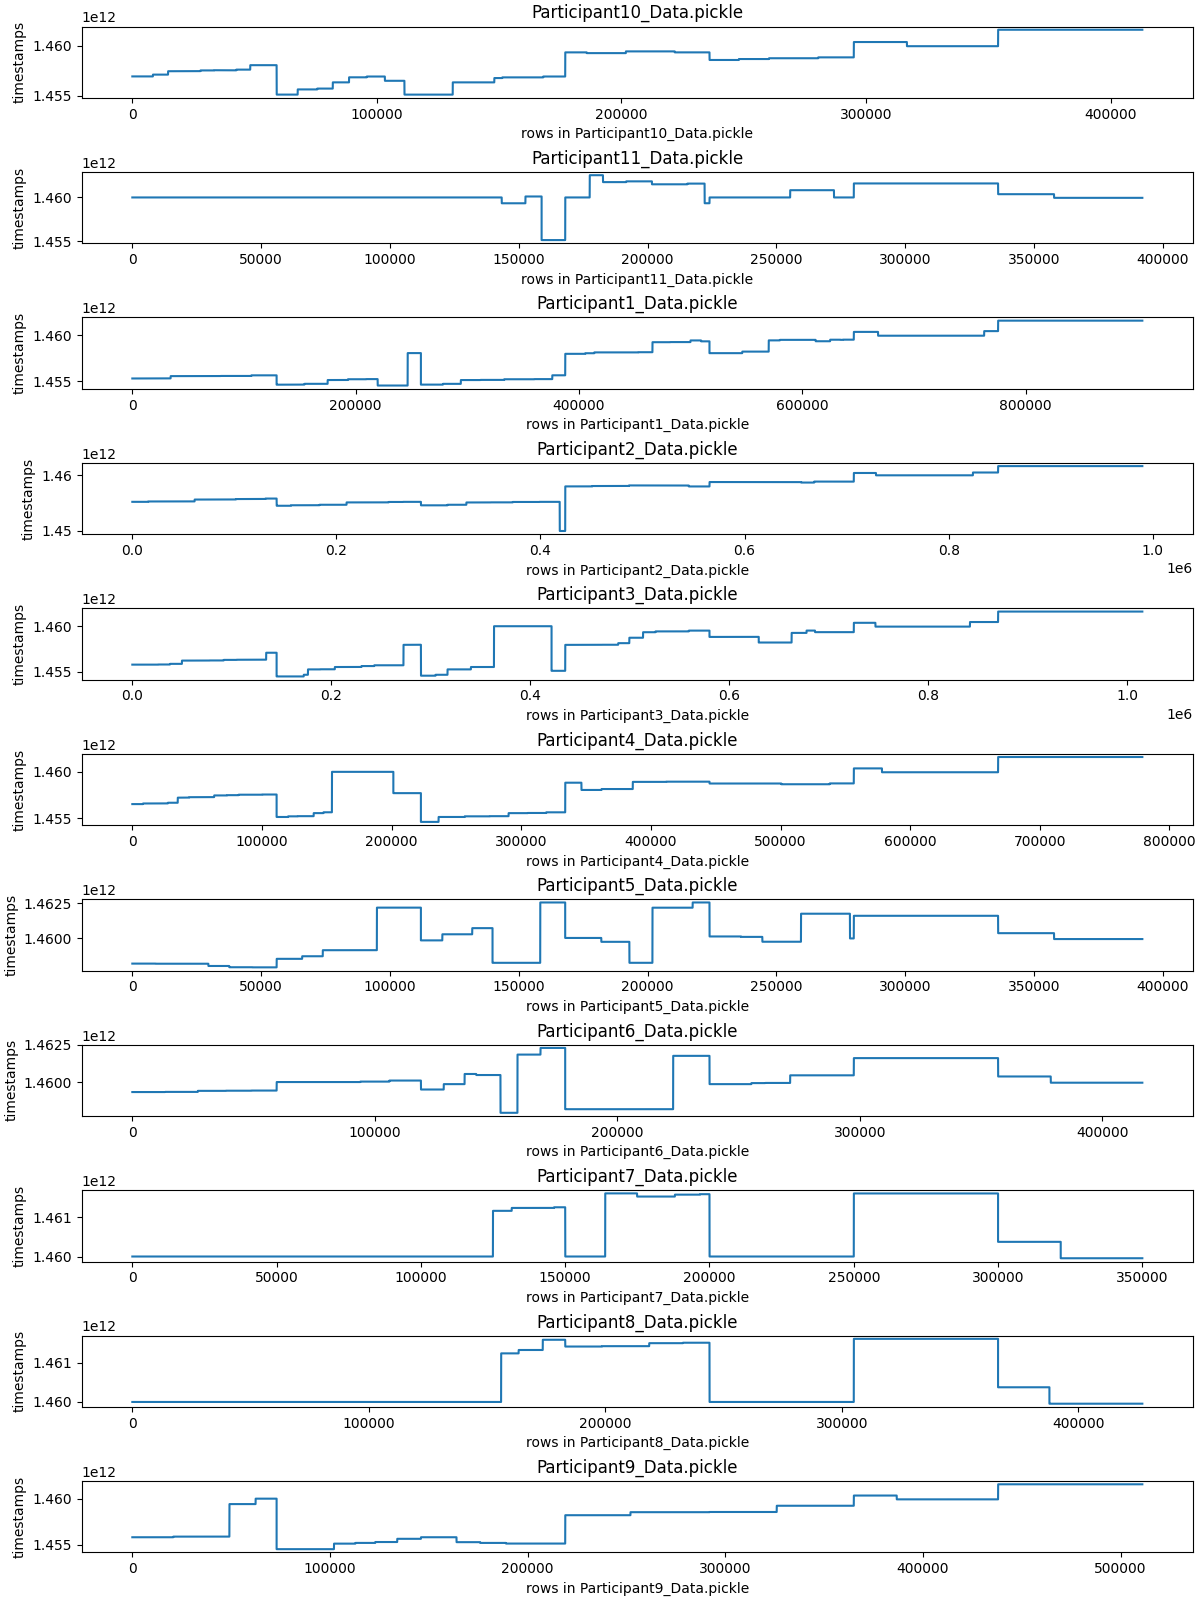

In [26]:
%matplotlib notebook
print_full_ts(pickles_dir)

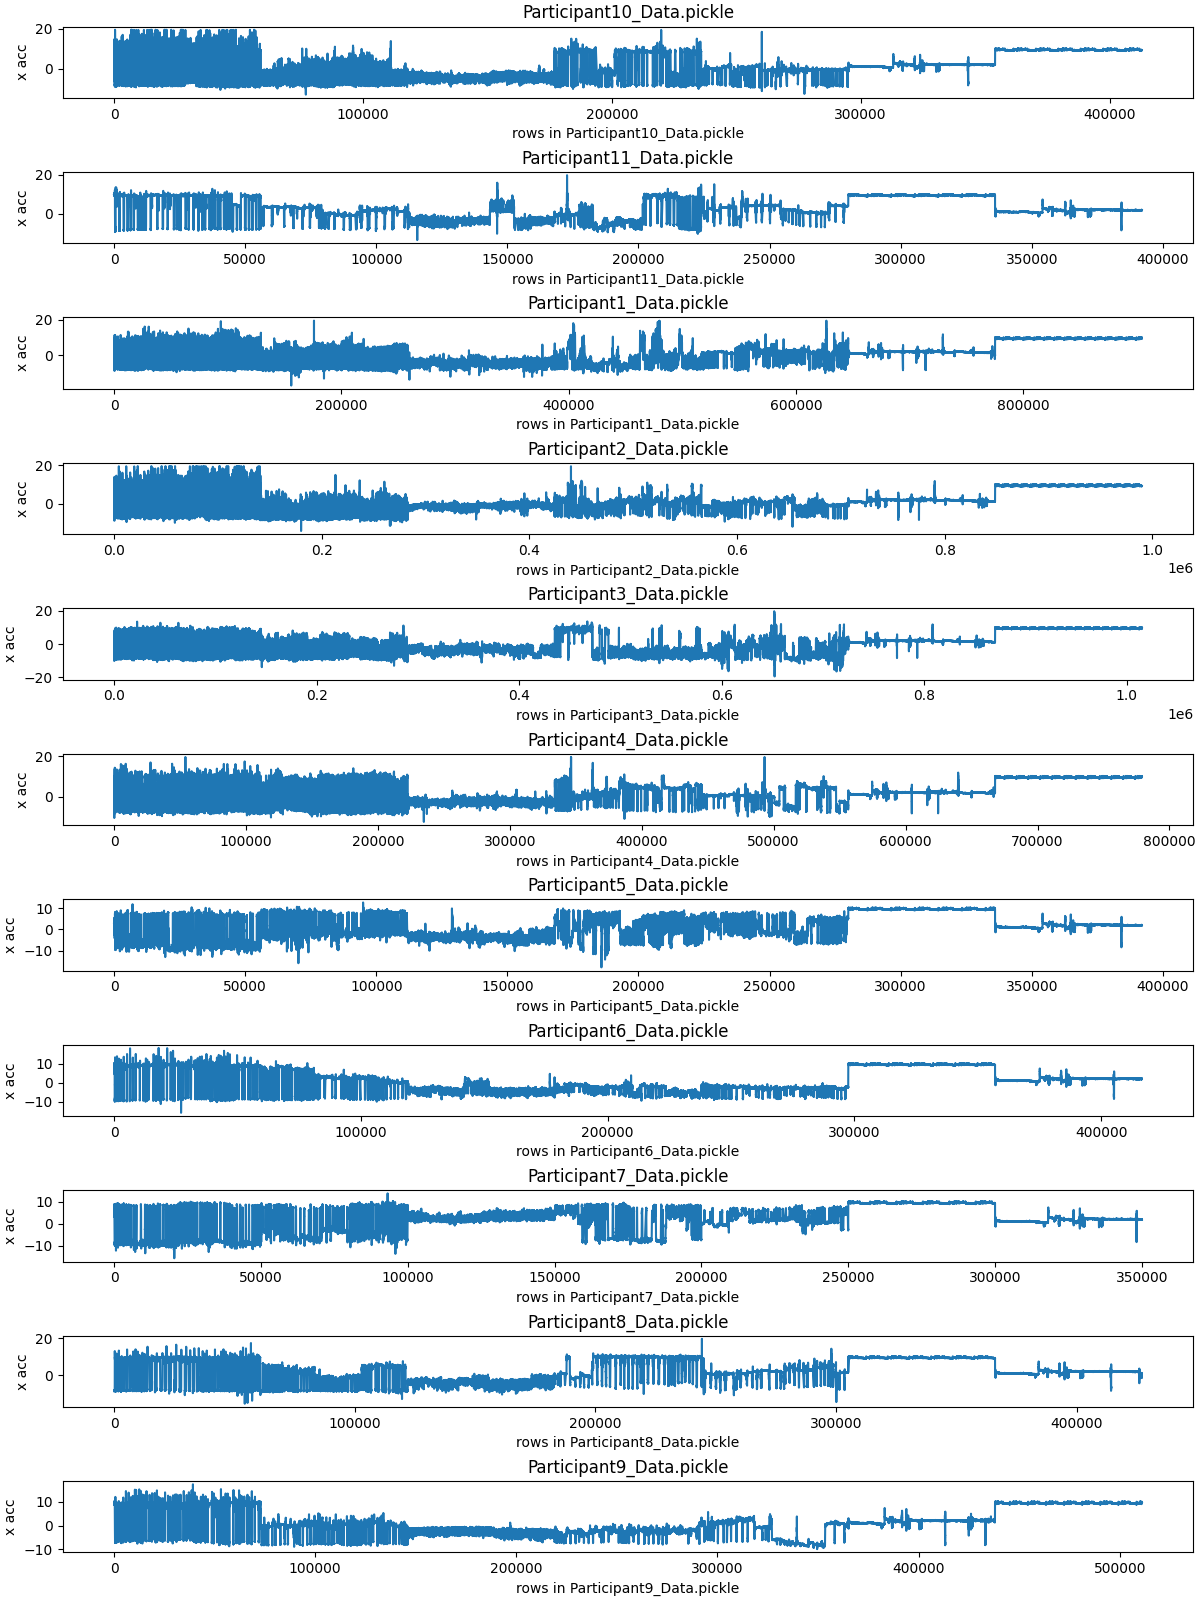

In [39]:
%matplotlib notebook
print_full_x_acc(pickles_dir)

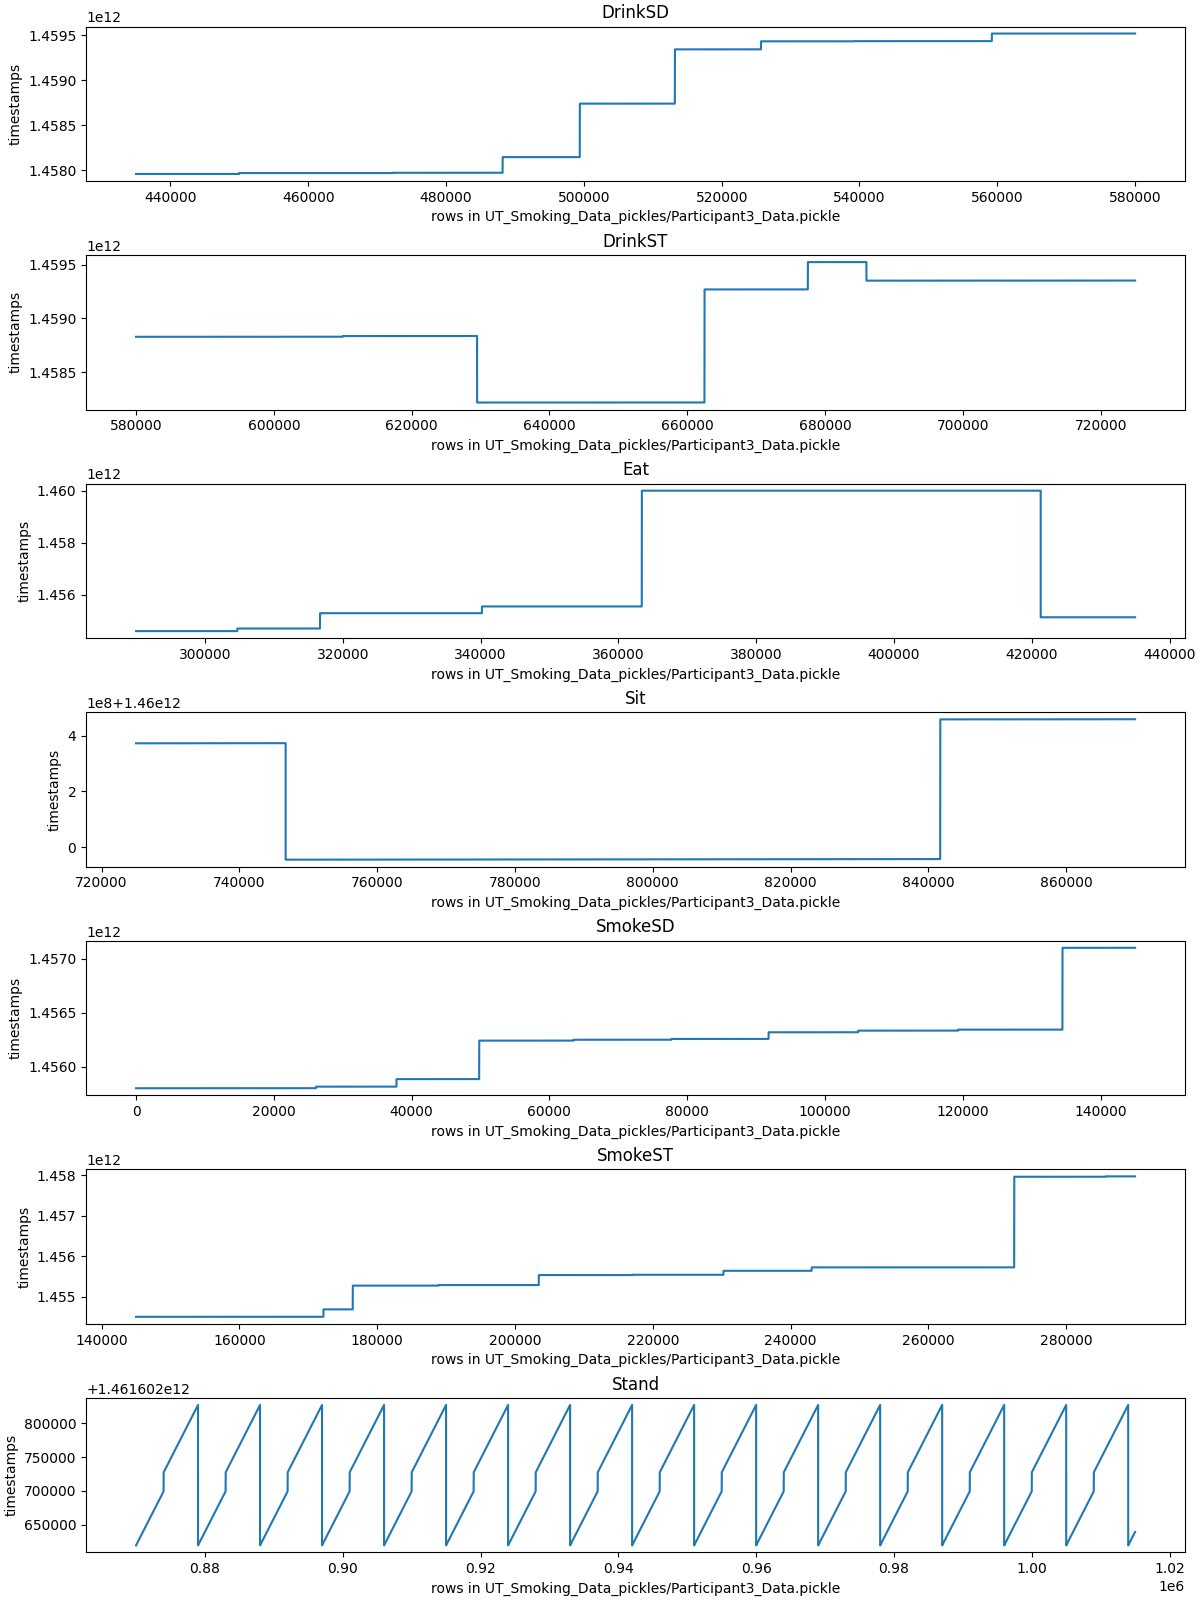

In [65]:
%matplotlib notebook
participant="Participant3"
fname='{}/{}_Data.pickle'.format(pickles_dir, participant)
data = pd.read_pickle(fname)
print_act_ts(fname, data)

<IPython.core.display.Javascript object>


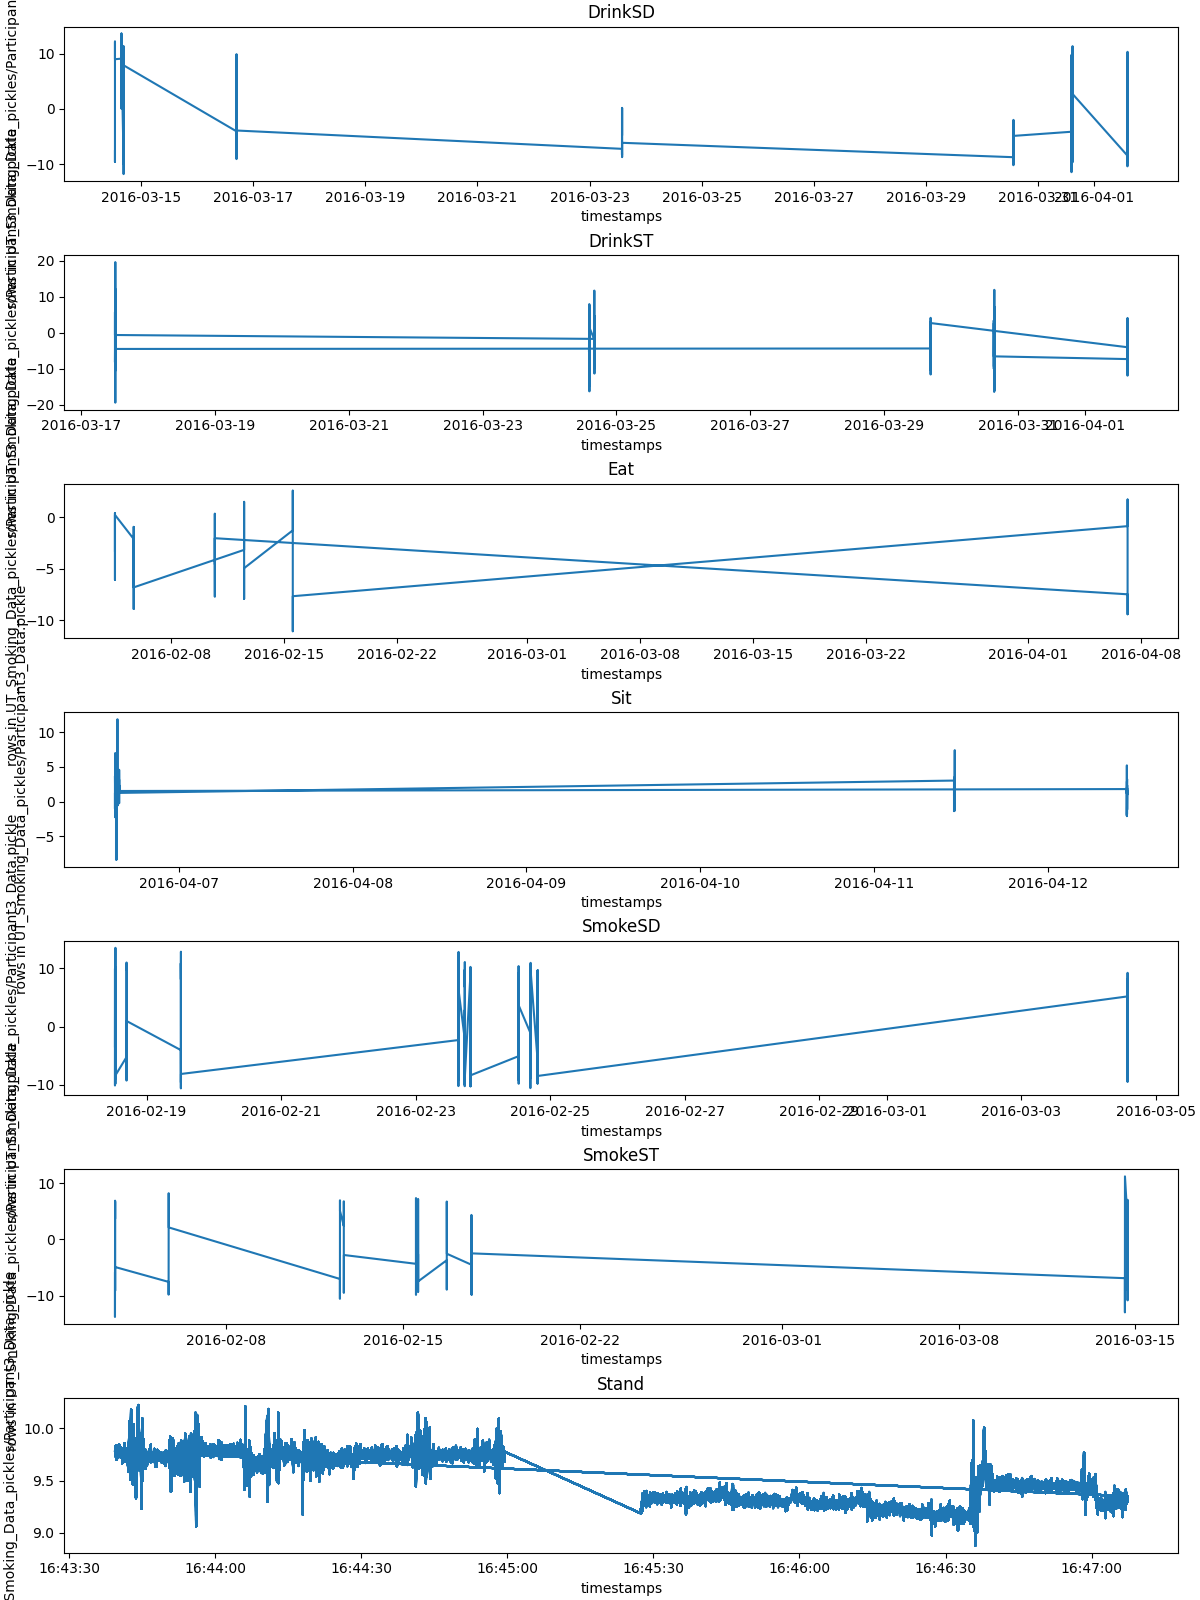

In [7]:
%matplotlib notebook
#u'll see why we need to sort by tyme each categ... here unsorted "wierdness"
participant="Participant3"
fname='{}/{}_Data.pickle'.format(pickles_dir, participant)
data = pd.read_pickle(fname)
act_types=np.sort(data[categ_colname].unique())
print_act_ts_inv(fname, data)

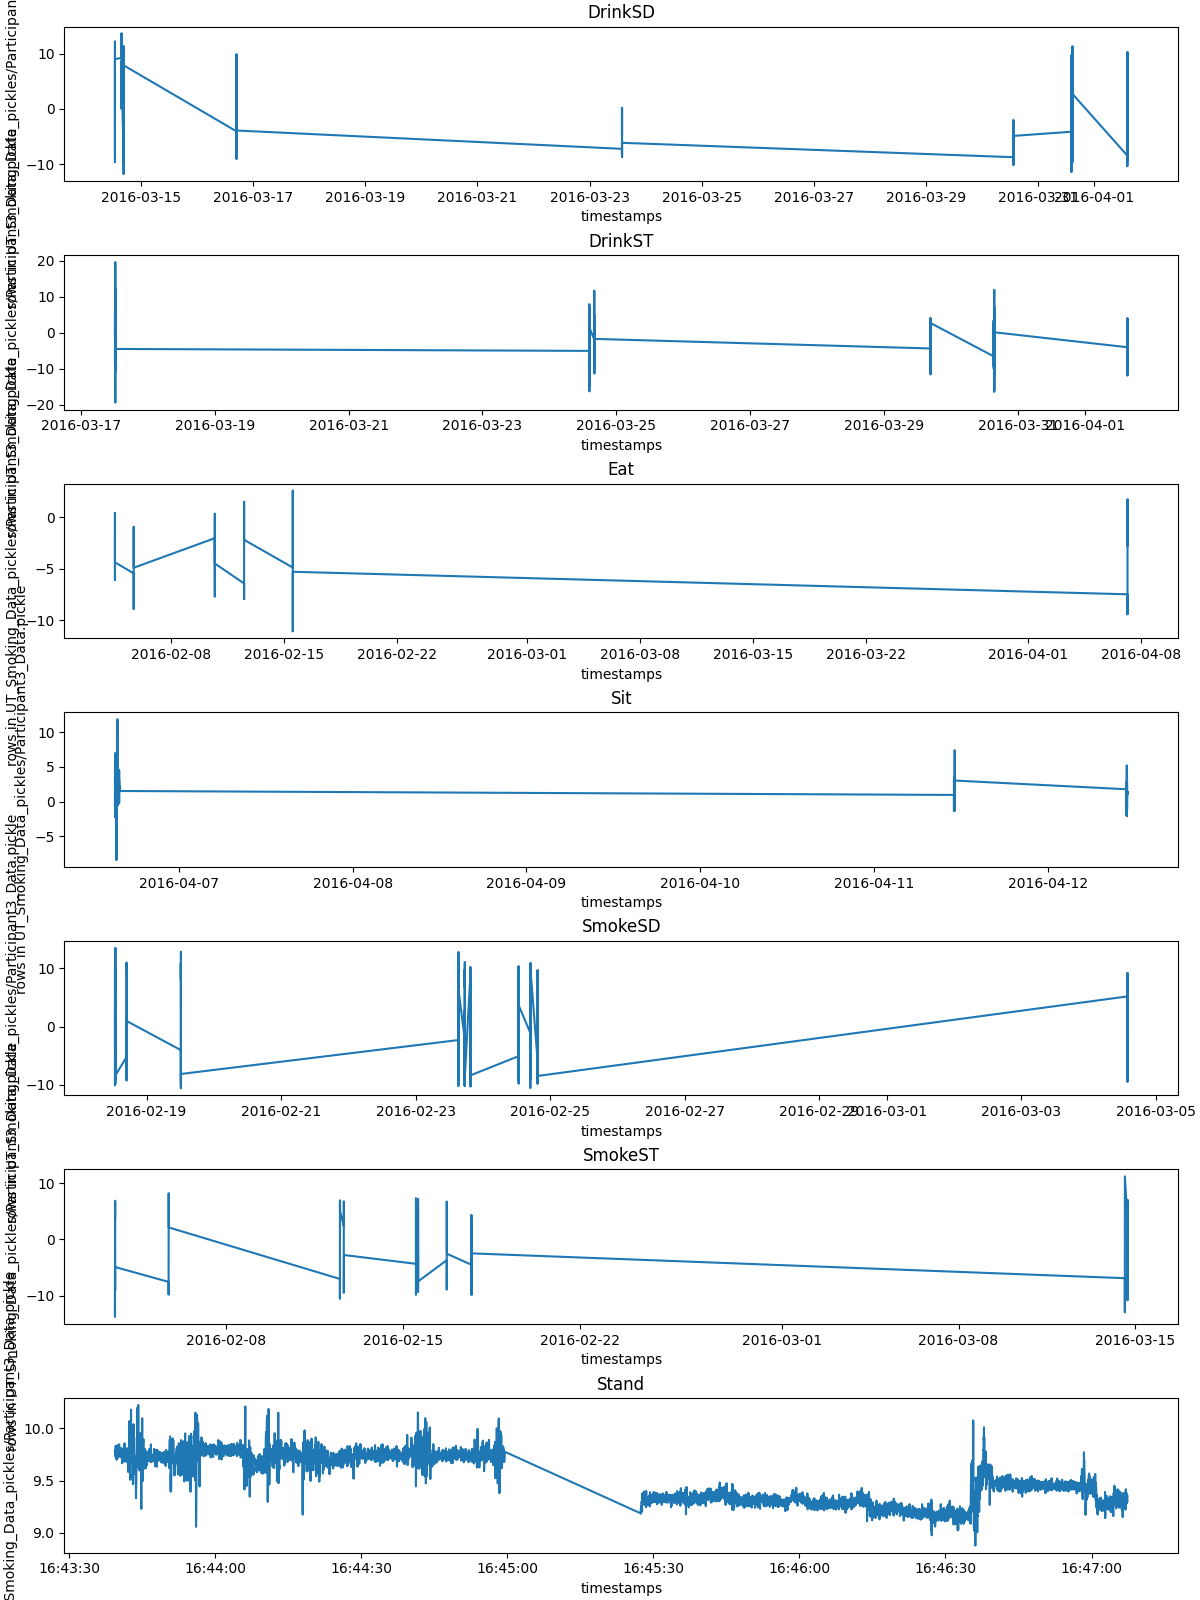

In [67]:
#sorted by time => everything gets smooth on timeline..
data2=data.sort_values(by=ts_field, ignore_index=True)
data2=data2.reset_index(drop=True)
print_act_ts_inv(fname, data2)

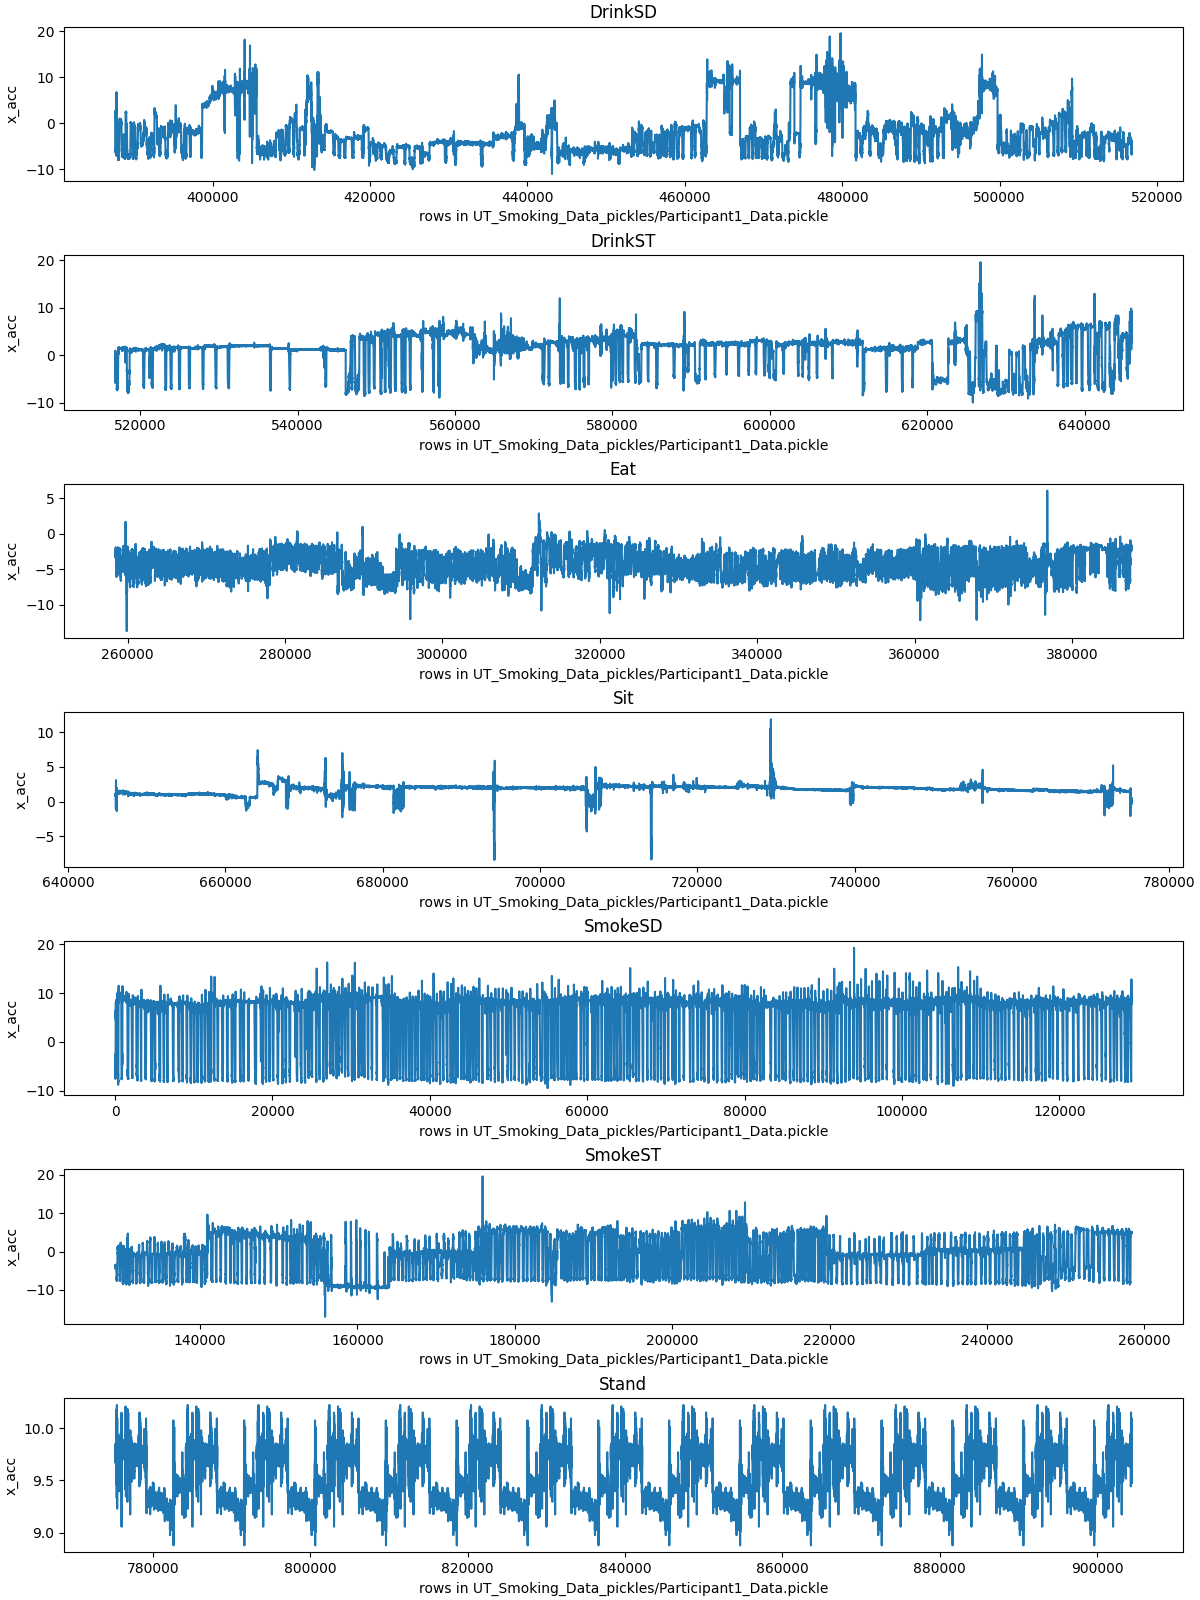

In [34]:
%matplotlib notebook
#data follows index
print_act_x_acc(fname, data)

<IPython.core.display.Javascript object>


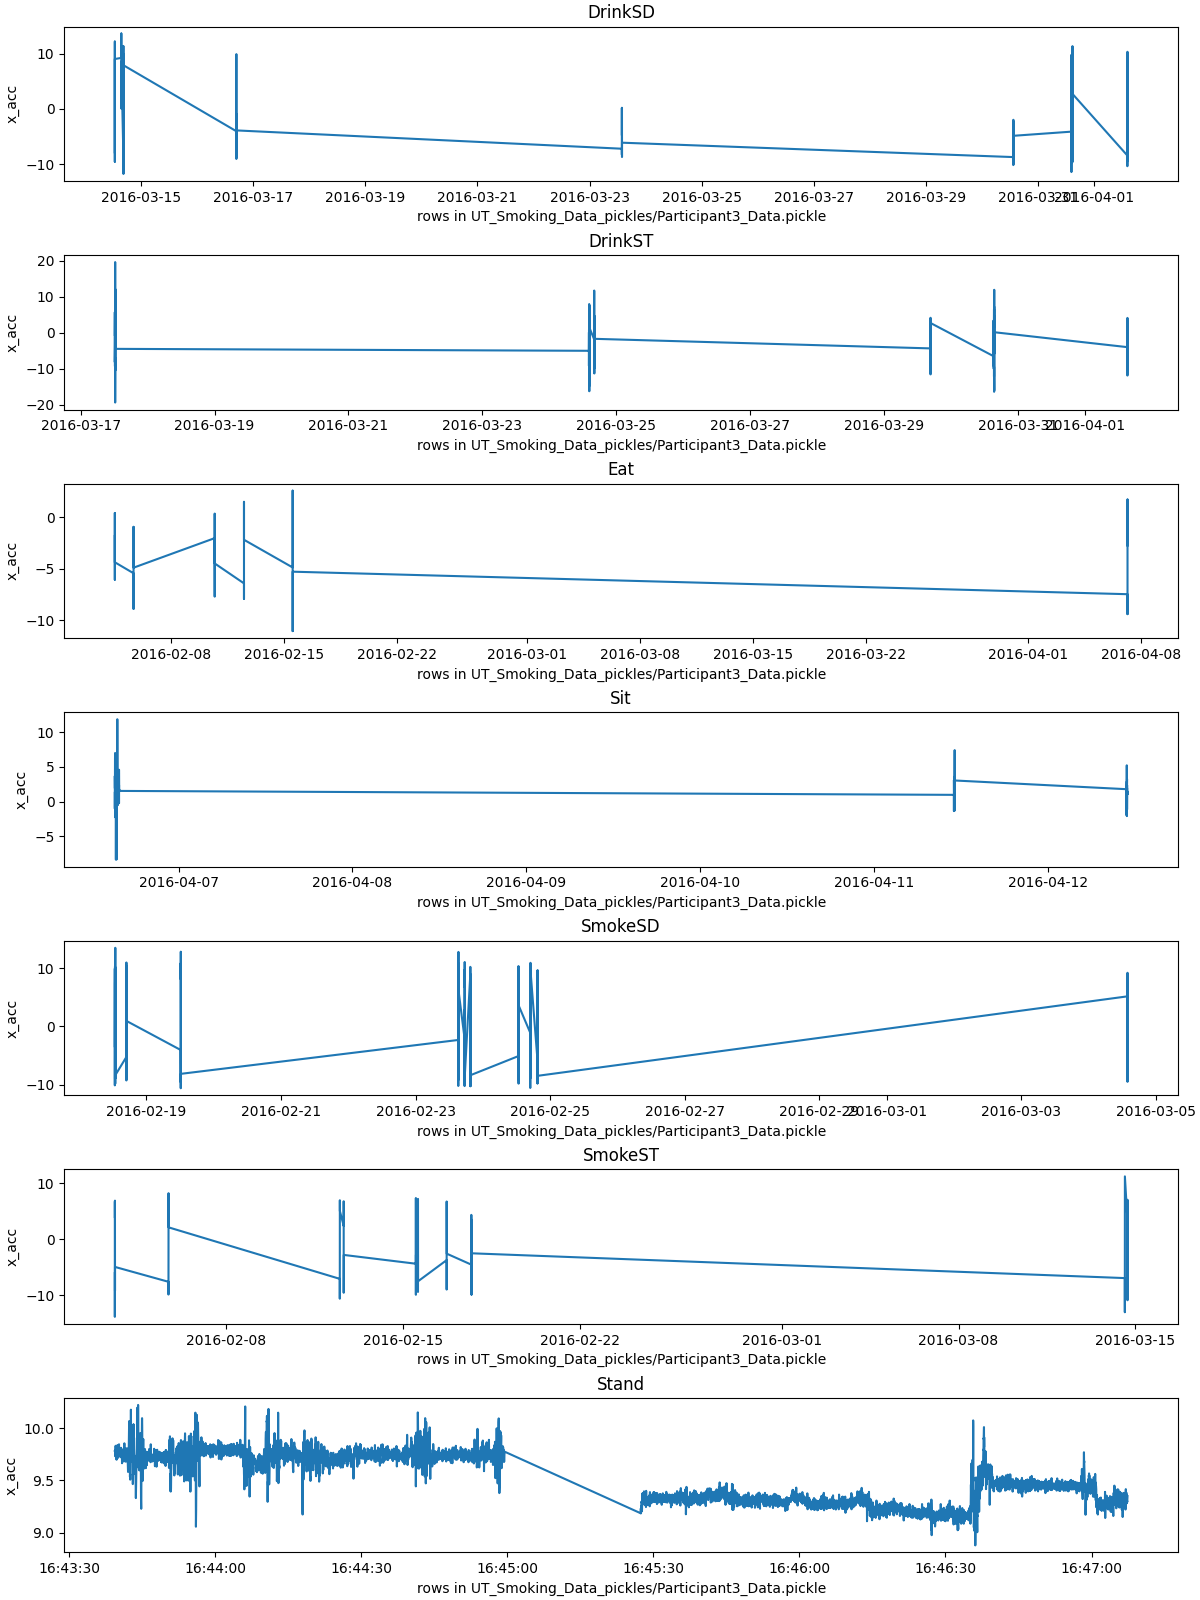

In [12]:
#sensor data time sorted
data2=data.sort_values(by=ts_field, ignore_index=True)
data2=data2.reset_index(drop=True)
print_act_x_acc_on_ts(fname, data2)

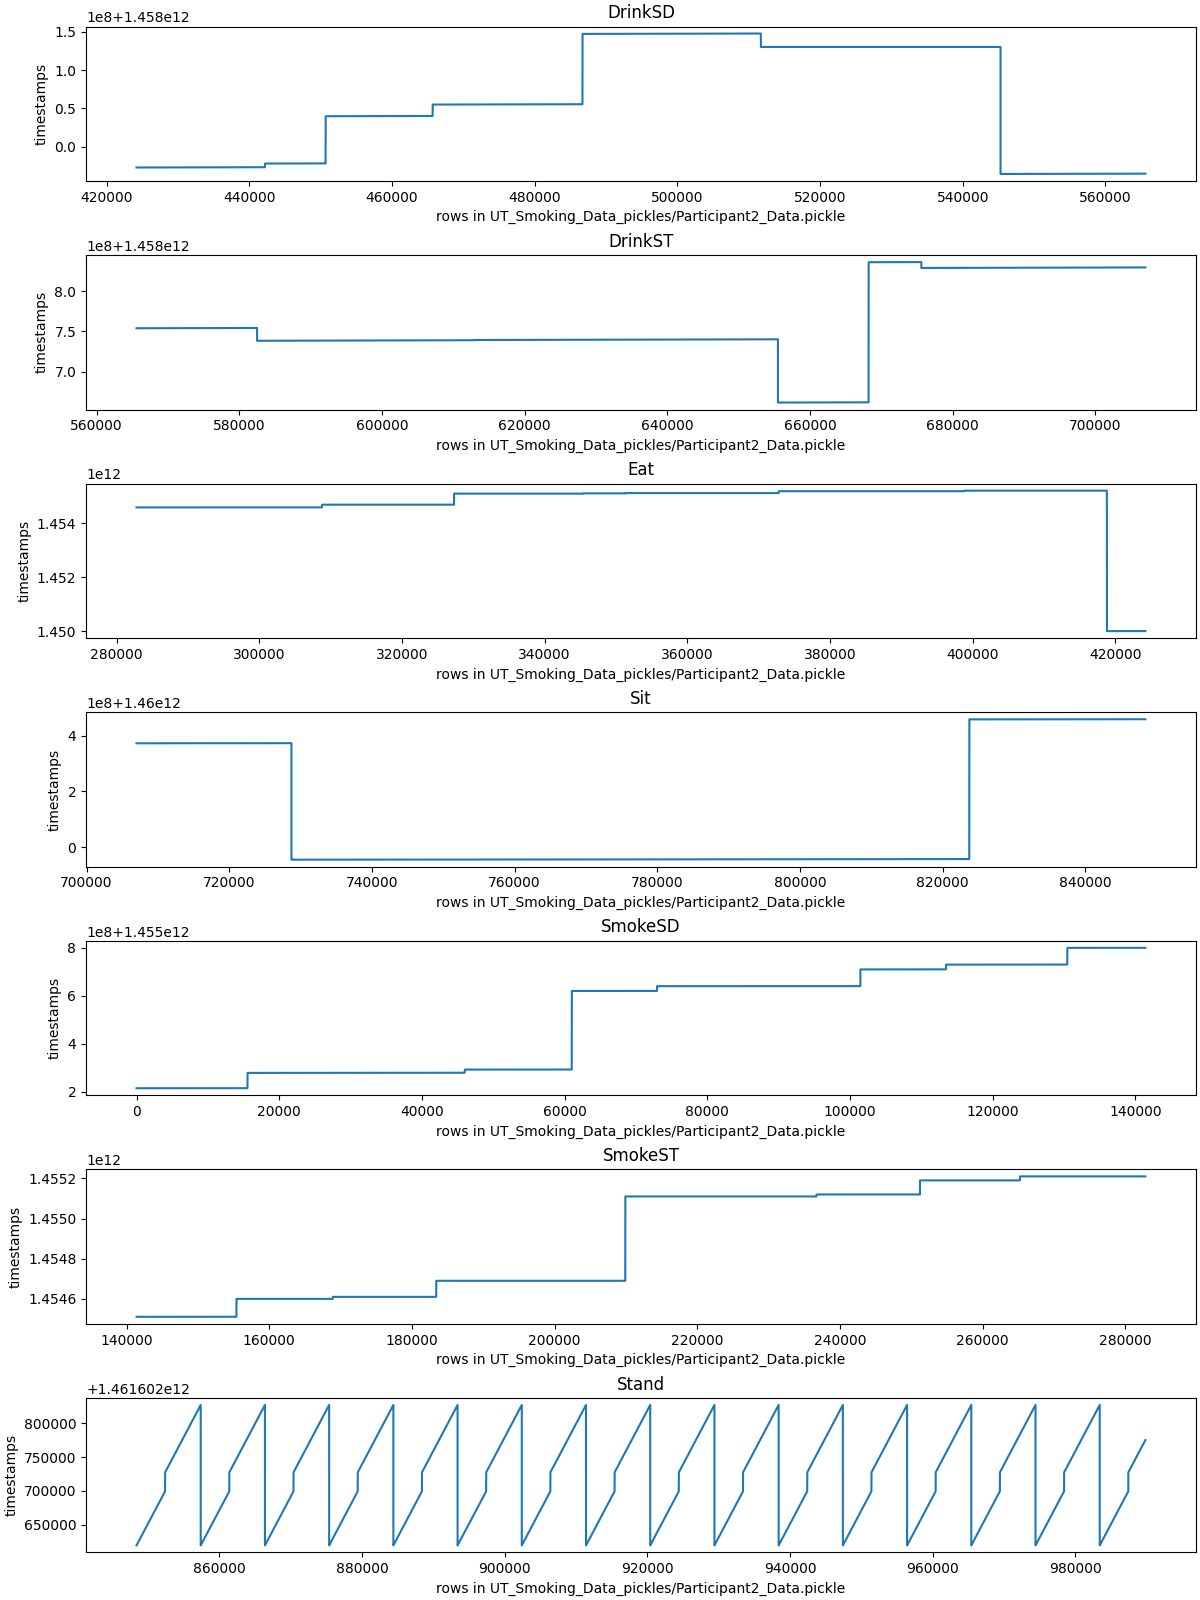

In [48]:
participant="Participant2"
fname='{}/{}_Data.pickle'.format(pickles_dir, participant)
data = pd.read_pickle(fname)
print_act_ts(fname, data)

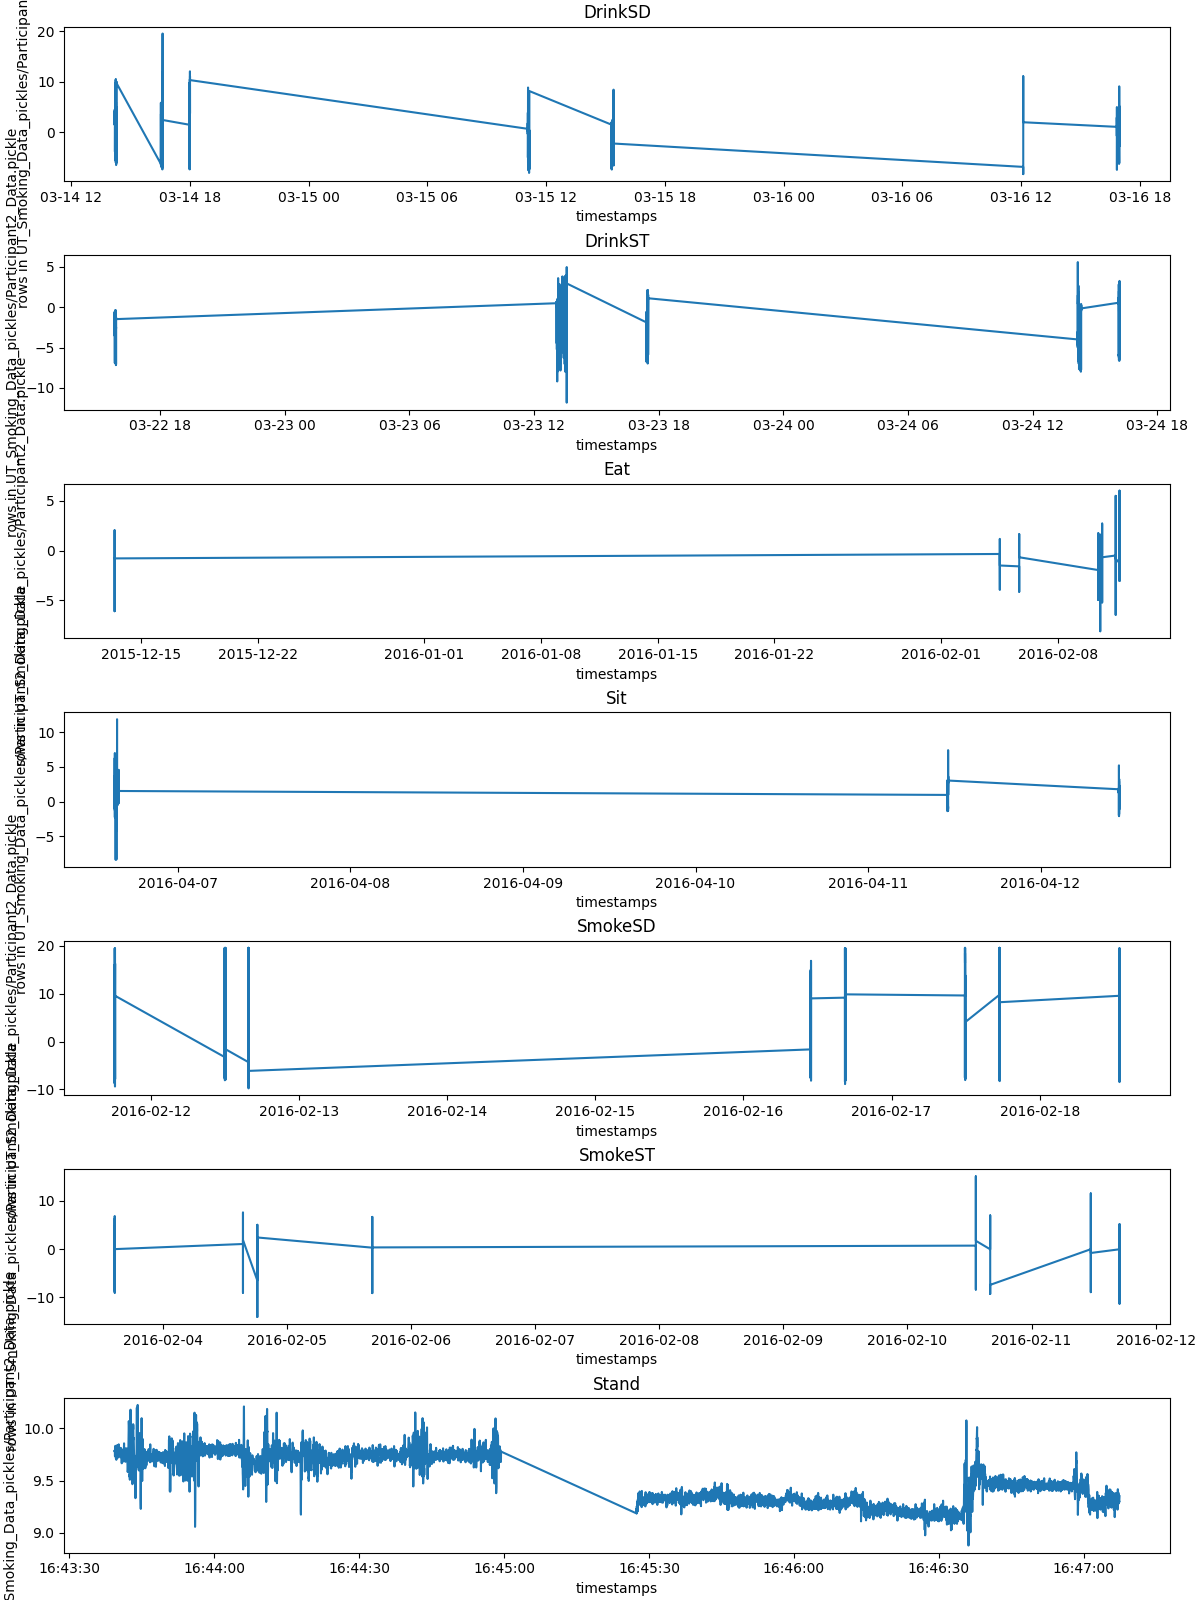

In [59]:
participant="Participant2"
fname='{}/{}_Data.pickle'.format(pickles_dir, participant)
data = pd.read_pickle(fname)
data2=data.sort_values(by=ts_field, ignore_index=True)
data2=data2.reset_index(drop=True)
print_act_ts_inv(fname, data2)